In [83]:
import numpy 
import cv2 
from torch import nn 
import torch 
import matplotlib.pyplot as plt
from torchvision import models
import typing


class GradCAM(object):
    
    """
    Gradient-based Class Activation Mapping 
    (method for visual interpretation of the Convolutional Neural Networks)
    
    Parameters:
    -----------
        - activations (typing.List) - list for storing network layer activations
        - grad (typing.List) - list for storing output gradients of the last convolutional layer
    """

    def __init__(self):
        self.activations = []
        self.grads = []

    @staticmethod
    def visualize_grad_cam_map(actual_img: numpy.ndarray, cam_map: numpy.ndarray):
        """
        Function visualizes map,
        generated from grad-cam.
        """
        heatmap = cv2.applyColorMap(
            cam_map.astype(numpy.uint8), 
            colormap=cv2.COLORMAP_JET
        )
        visual_map = (actual_img * 0.7 + heatmap * 0.3).astype(numpy.uint8)
        plt.imshow(visual_map)

    def _track_forward_hook(self, module: nn.Module, input: torch.Tensor, output: torch.Tensor):
        self.activations.append(output)

    def _track_backward_hook(self, module: nn.Module, input_grad: torch.Tensor, output_grad: torch.Tensor):
        self.grads.append(output_grad[0])

    def _register_tracking_hooks(self, last_layer: nn.Module):

        self.forward_hook = last_layer.register_forward_hook(hook=self._track_forward_hook)
        self.backward_hook = last_layer.register_backward_hook(hook=self._track_backward_hook)

    def _remove_hooks(self):
        """
        Removes registered 
        forward and backward hooks
        """
        self.forward_hook.remove()
        self.backward_hook.remove()
        
    def compute_grad_cam(
        self, 
        network: nn.Module, 
        input_img: numpy.ndarray,
        target_label: int,
    ):
        """
        Function computes gradient-based
        Class Activation Mapping 
        
        Parameters:
        -----------
        
        network - convolutional-based neural network for making predictions
        input_img - (numpy.ndarray) RGB image to be interpreted
        target_label - class of the object you want to observe on the image
        """

        # converting image to C-like ordered array 
        # (NOTE: gives error, if you remove this line) 

        img = input_img.copy()
        img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        img = numpy.ascontiguousarray(img)

        # converting to torch representation and expand dimension for the batch
        torch_img = torch.from_numpy(   
            img.astype(numpy.uint8)
        ).permute(2, 0, 1).unsqueeze(0)
        
        # registering hooks for capturing activations and gradients
        last_layer = network.layer4[-1]
        self._register_tracking_hooks(last_layer=last_layer)
        
        # running image through the network (training mode)
        predictions = network(torch_img.float())

        network.zero_grad()
        predictions[0, target_label].backward()

        # obtaining gradients and feature maps
        img_grads = self.grads[0].cpu().data.numpy().squeeze()
        feature_maps = self.activations[0].cpu().data.numpy().squeeze()

        # calculating weights for each feature map
        res_grad = img_grads.reshape([img_grads.shape[0], -1])
        weights = numpy.mean(res_grad, axis=1)

            # calculating class activation map (CAM)
        cam = numpy.zeros(shape=img_grads.shape[1:])
        
        for idx, weight in enumerate(weights):
            cam += weight * feature_maps[idx, :]
            
        # normalizing cam to be in range [0, 255]
        
        cam = (cam > 0) * cam
        cam = cam/cam.max()*255
        
        # resizing image to the original shape of the image
        
        resized_cam = cv2.resize(
            src=cam, 
            dsize=(input_img.shape[1], input_img.shape[0]), 
            interpolation=cv2.INTER_CUBIC
        )
        
        self._remove_hooks()
        return resized_cam

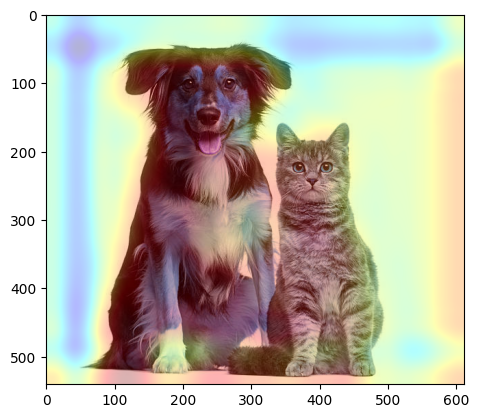

In [86]:
def test_cam():

    input_img = cv2.imread("./test_cat_dog_img.jpeg", 1)
  
    network = models.resnet50(pretrained=True)
    network.eval()
    
    cam = GradCAM()

    cam_mask = cam.compute_grad_cam(
        network=network,
        input_img=input_img,
        target_label=281,
    )

    # visualizing computed grad-based CAM mask
    cam.visualize_grad_cam_map(actual_img=input_img, cam_map=cam_mask)

test_cam()